## Content

- [Imports](#Imports)

- [Classification Metrics](#Classification-Metrics)

- [Data Ingestion & Split](#Data-Ingestion-&-Split)

- [Random Forest Classification](#Random-Forest-Classification)

- [Ada Boost Classification](#Ada-Boost-Classification)

- [XG Boost Classification](#XG-Boost-Classification)

- [Isolation Forest Classification](#Isolation-Forest-Classification)

    - [a. With original outlier_fraction](#a.-With-original-outlier_fraction)

    - [b. Without original outlier_fraction](#b.-Without-original-outlier_fraction)

- [Local Outlier Factor](#Local-Outlier-Factor)

    - [c. With original outlier_fraction](#c.-With-original-outlier_fraction)

    - [d. Without original outlier_fraction](#d.-Without-original-outlier_fraction)

- [Conclusion](#Conclusion)

### Imports

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, average_precision_score, precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, IsolationForest
from sklearn.neighbors import LocalOutlierFactor
import xgboost as xgb

### Classification Metrics

In [42]:
RFC_METRIC = 'gini'  #metric used for RandomForrestClassifier
NUM_ESTIMATORS = 100 #number of estimators used for RandomForrestClassifier
NO_JOBS = 4 #number of parallel jobs used for RandomForrestClassifier


#TRAIN/VALIDATION/TEST SPLIT
#VALIDATION
VALID_SIZE = 0.20 # simple validation using train_test_split
TEST_SIZE = 0.20 # test size using_train_test_split

RANDOM_STATE = 2024

MAX_ROUNDS = 1000 #xgb iterations
EARLY_STOP = 50 #xgb early stop 
VERBOSE_EVAL = 50 #Print out metric result

### Data Ingestion & Split

In [43]:
pd.set_option('display.max_columns', None)
pd.set_option("display.max_rows", 100)

df = pd.read_csv('creditcard.csv',sep=',')
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [44]:
predictors = list(df.columns.values[:-1])
target = df.columns.values[-1]

In [45]:
# Get the Fraud & Normal dataset 

fraud_df    = df[df['Class']==1]
normal_df   = df[df['Class']==0]
print(fraud_df.shape, normal_df.shape)
print(f"Fraud-to-Normal transaction: {fraud_df.shape[0]/normal_df.shape[0]}")

(492, 31) (284315, 31)
Fraud-to-Normal transaction: 0.0017304750013189597


In [46]:
train_without_validation_df_N, test_df_N = train_test_split(normal_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_with_validation_df_N, valid_df_N = train_test_split(train_without_validation_df_N, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [47]:
train_without_validation_df_F, test_df_F = train_test_split(fraud_df, test_size=TEST_SIZE, random_state=RANDOM_STATE, shuffle=True )
train_with_validation_df_F, valid_df_F = train_test_split(train_without_validation_df_F, test_size=VALID_SIZE, random_state=RANDOM_STATE, shuffle=True )

In [48]:
train_without_validation_df = pd.concat([train_without_validation_df_N, train_without_validation_df_F], ignore_index=True)
train_with_validation_df = pd.concat([train_with_validation_df_N, train_with_validation_df_F], ignore_index=True)
valid_df = pd.concat([valid_df_N, valid_df_F], ignore_index=True)
test_df = pd.concat([test_df_N, test_df_F], ignore_index=True)

### Random Forest Classification

Validation criterion GINI, formula GINI = 2 * (AUC) - 1, where AUC is the Receiver Operating Characteristic - Area Under Curve (ROC-AUC).

Number of estimators is set to 100 and number of parallel jobs is set to 4.

In [49]:
# Classification model

rf_clf = RandomForestClassifier(n_jobs=NO_JOBS, 
                                random_state=RANDOM_STATE,
                                criterion=RFC_METRIC,
                                n_estimators=NUM_ESTIMATORS,
                                verbose=False)

# Fit the model

rf_clf.fit(train_without_validation_df[predictors], train_without_validation_df[target])

RandomForestClassifier(n_jobs=4, random_state=2024, verbose=False)

C:\Users\arkan\AppData\Local\Temp\ipykernel_14728\3587461074.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


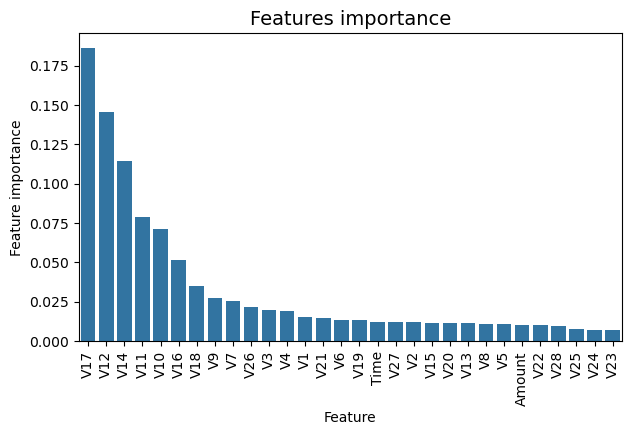

In [50]:
# Feature importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': rf_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

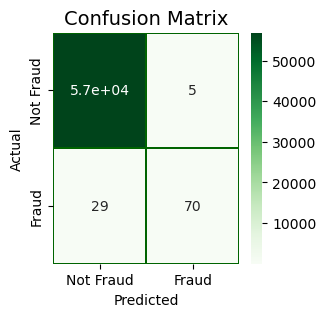

In [51]:
# Predictions

predictions = rf_clf.predict(test_df[predictors])

# Confusion matrix

cm = pd.crosstab(test_df[target].values, predictions, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [52]:
# Classification Report

print(classification_report(test_df[target].values, predictions, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with RandomForrestClassifier is {average_precision_score (test_df[target].values, predictions):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.93      0.71      0.80        99

    accuracy                           1.00     56962
   macro avg       0.97      0.85      0.90     56962
weighted avg       1.00      1.00      1.00     56962

Avg. Precision Score with RandomForrestClassifier is 0.6604


### Ada Boost Classification

In [53]:
# Classification model

ada_clf = AdaBoostClassifier(random_state=RANDOM_STATE,
                            algorithm='SAMME',
                            learning_rate=0.8,
                            n_estimators=NUM_ESTIMATORS)    # Default estimator is DecisionTreeClassifier initialized with max_depth=1

# Fit the model

ada_clf.fit(train_without_validation_df[predictors], train_without_validation_df[target])

AdaBoostClassifier(algorithm='SAMME', learning_rate=0.8, n_estimators=100,
                   random_state=2024)

C:\Users\arkan\AppData\Local\Temp\ipykernel_14728\3782090346.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  s.set_xticklabels(s.get_xticklabels(),rotation=90)


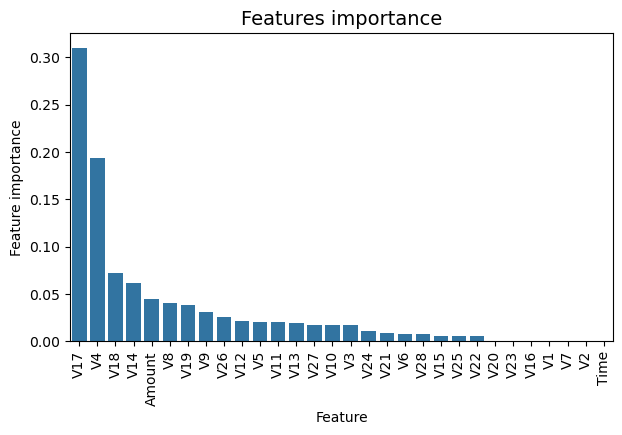

In [54]:
# Feature importance

tmp = pd.DataFrame({'Feature': predictors, 'Feature importance': ada_clf.feature_importances_})
tmp = tmp.sort_values(by='Feature importance',ascending=False)
plt.figure(figsize = (7,4))
plt.title('Features importance',fontsize=14)
s = sns.barplot(x='Feature',y='Feature importance',data=tmp)
s.set_xticklabels(s.get_xticklabels(),rotation=90)
plt.show()

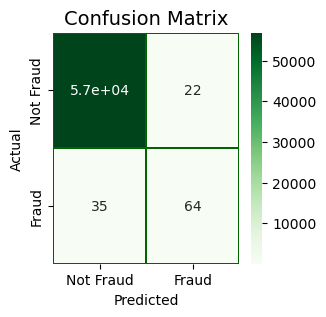

In [55]:
# Predictions

predictions = ada_clf.predict(test_df[predictors])

# Confusion matrix

cm = pd.crosstab(test_df[target].values, predictions, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [56]:
# Classification Report

print(classification_report(test_df[target].values, predictions, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with AdaBoostClassifier is {average_precision_score (test_df[target].values, predictions):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.74      0.65      0.69        99

    accuracy                           1.00     56962
   macro avg       0.87      0.82      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Avg. Precision Score with AdaBoostClassifier is 0.4817


### XG Boost Classification

In [57]:
# Prepare the train and valid datasets

dtrain = xgb.DMatrix(train_with_validation_df[predictors], train_with_validation_df[target].values)
dvalid = xgb.DMatrix(valid_df[predictors], valid_df[target].values)
dtest = xgb.DMatrix(test_df[predictors], test_df[target].values)

# What to monitor (in this case, **train** and **valid**)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Outlier fraction

outlier_fraction = 0.0017304750013189597 # len(Fraud)/len(Not Fraud), retrived from the data_exploration.ipynb

# Set xgboost parameters

params = {}
params['objective'] = 'binary:logistic'
params['eta'] = 0.08
params['max_depth'] = 5
params['subsample'] = 0.8
params['colsample_bytree'] = 0.9
params['eval_metric'] = 'map' # 'aucpr', 'map'
params['random_state'] = RANDOM_STATE
params['scale_pos_weight'] = 1/outlier_fraction # len(y_train[y_train==0]) / len(y_train[y_train==1])
params['min_child_weight'] = 30
# params['gamma'] = 0.0         # Increasing the value degrades the model performance, hence set to default 0.0
# params['lambda'] = 15         # No effect on the model
# params['alpha'] = 5           # No effect on the model

In [58]:
# Classification model

xg_clf = xgb.train(params,
                    dtrain,
                    MAX_ROUNDS,
                    watchlist,
                    early_stopping_rounds=EARLY_STOP,
                    maximize=True,
                    verbose_eval=VERBOSE_EVAL)

c:\ProgramData\anaconda3\Lib\site-packages\xgboost\core.py:726: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[0]	train-map:0.00000	valid-map:0.07263
[50]	train-map:0.58779	valid-map:0.46762
[100]	train-map:0.96572	valid-map:0.96465
[150]	train-map:1.00000	valid-map:0.96777
[200]	train-map:1.00000	valid-map:0.96465
[206]	train-map:1.00000	valid-map:0.96572


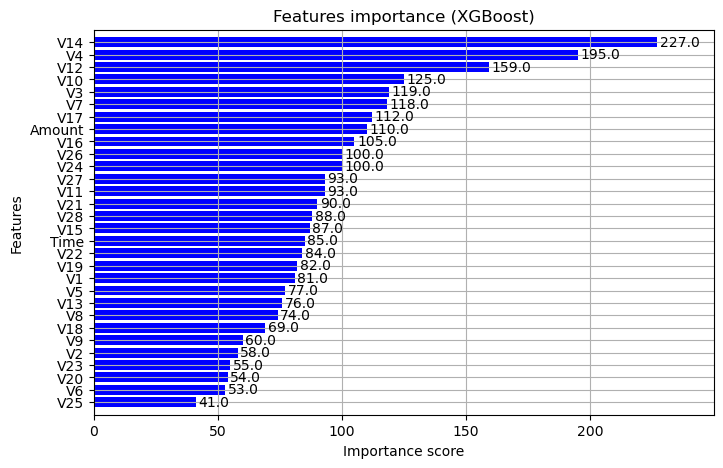

In [59]:
# Feature importance

fig, (ax) = plt.subplots(ncols=1, figsize=(8,5))
xgb.plot_importance(xg_clf, height=0.8, title="Features importance (XGBoost)", ax=ax, color="blue") 
plt.show()

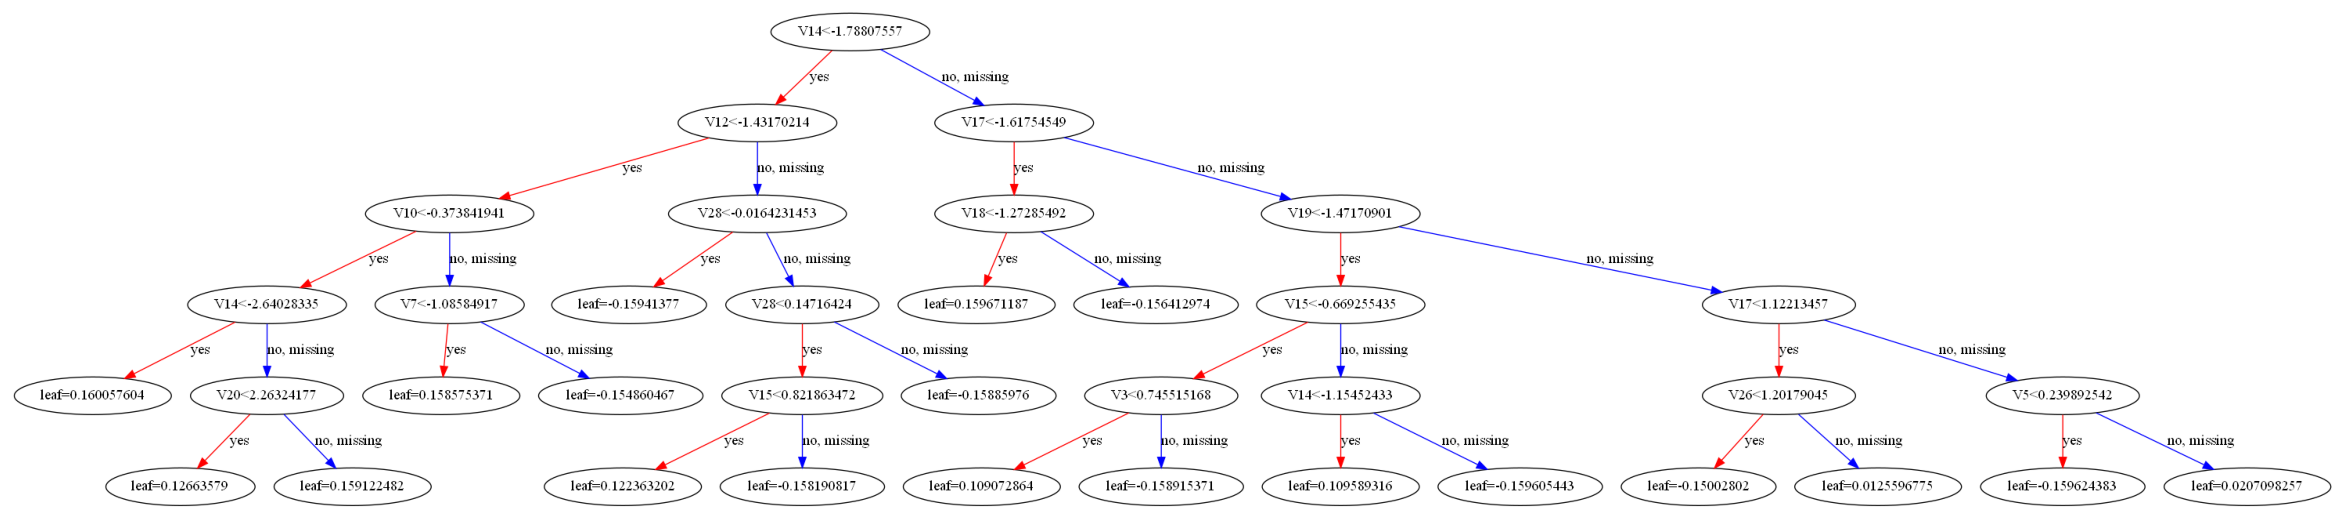

In [60]:
rcParams['figure.figsize'] = 30,10
xgb.plot_tree(xg_clf)
plt.show()

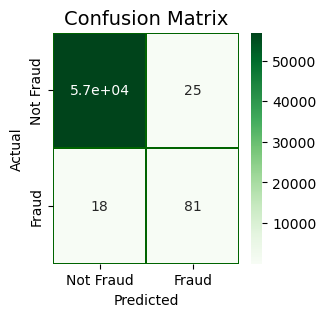

In [61]:
# Predictions

predictions = xg_clf.predict(dtest)

# Convert probabilities to class labels if it's a binary/multi-class classification

y_pred = (predictions > 0.5).astype(int) # For binary classification

# Confusion matrix

cm = pd.crosstab(test_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [62]:
# Classification Report

print(classification_report(test_df[target].values, y_pred, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with XGBoostClassifier is {average_precision_score (test_df[target].values, y_pred):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.76      0.82      0.79        99

    accuracy                           1.00     56962
   macro avg       0.88      0.91      0.89     56962
weighted avg       1.00      1.00      1.00     56962

Avg. Precision Score with XGBoostClassifier is 0.6255


### Isolation Forest Classification

One of the newest techniques to detect anomalies is called Isolation Forests. It is an unsupervised model. The algorithm is based on the fact that anomalies are data points that are few and different. As a result of these properties, anomalies are susceptible to a mechanism called isolation.

This method is highly useful and is fundamentally different from all existing methods. It introduces the use of isolation as a more effective and efficient means to detect anomalies than the commonly used basic distance and density measures. Moreover, this method is an algorithm with a low linear time complexity and a small memory requirement. It builds a good performing model with a small number of trees using small sub-samples of fixed size, regardless of the size of a data set.

Typical machine learning methods tend to work better when the patterns they try to learn are balanced, meaning the same amount of good and bad behaviors are present in the dataset.

How Isolation Forests Works?
The Isolation Forest algorithm isolates observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature. The logic argument goes: isolating anomaly observations is easier because only a few conditions are needed to separate those cases from the normal observations. On the other hand, isolating normal observations require more conditions. Therefore, an anomaly score can be calculated as the number of conditions required to separate a given observation.

The way that the algorithm constructs the separation is by first creating isolation trees, or random decision trees. Then, the score is calculated as the path length to isolate the observation.

##### a. With original outlier_fraction

In [63]:
# Outlier fraction

outlier_fraction = 0.0017304750013189597 # len(Fraud)/len(Not Fraud), retrived from the data_exploration.ipynb

# Classification model

iso_clf = IsolationForest(n_estimators=NUM_ESTIMATORS,
                        max_samples=len(train_without_validation_df),
                        contamination=outlier_fraction,
                        random_state=RANDOM_STATE,
                        verbose=False,
                        n_jobs=NO_JOBS,
                        max_features=len(predictors))

# Fit the model

iso_clf.fit(train_without_validation_df[predictors])

IsolationForest(contamination=0.0017304750013189597, max_features=30,
                max_samples=227845, n_jobs=4, random_state=2024, verbose=False)

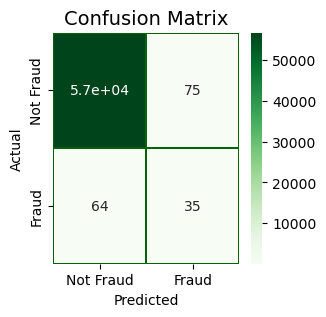

In [64]:
# Predictions

predictions = iso_clf.predict(test_df[predictors])

# Convert predictions +1 or -1 to the class of 0 or 1 respectively (Anomaly is -1)

y_pred = [1 if i == -1 else 0 for i in predictions]  # Convert -1 to 1 (Fraud) and 1 to 0 (Not Fraud)

# Confusion matrix

cm = pd.crosstab(test_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [65]:
# Classification Report

print(classification_report(test_df[target].values, y_pred, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with IsolationForestClassifier is {average_precision_score (test_df[target].values, y_pred):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.32      0.35      0.33        99

    accuracy                           1.00     56962
   macro avg       0.66      0.68      0.67     56962
weighted avg       1.00      1.00      1.00     56962

Avg. Precision Score with IsolationForestClassifier is 0.1136


##### b. Without original outlier_fraction

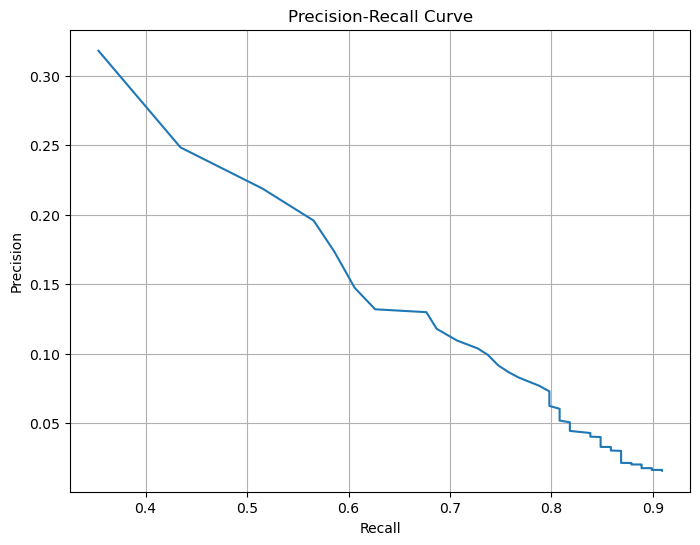

In [66]:
rc = []
pc = []
i = outlier_fraction
while i <= 0.1:
    iso_clf = IsolationForest(n_estimators=NUM_ESTIMATORS,
                              max_samples=len(train_without_validation_df),
                              contamination=i,
                              random_state=RANDOM_STATE,
                              verbose=False,
                              n_jobs=NO_JOBS,
                              max_features=len(predictors))
    iso_clf.fit(train_without_validation_df[predictors])
    
    # Predictions
    y_pred = iso_clf.predict(test_df[predictors])
    
    # Convert -1 to 1 (outlier) and 1 to 0 (inlier)
    y_pred = [1 if i == -1 else 0 for i in y_pred]
    
    # Classification Report
    rc.append(recall_score(test_df[target].values, y_pred))
    pc.append(precision_score(test_df[target].values, y_pred))
    i += 0.001

plt.figure(figsize=(8, 6))
plt.plot(rc, pc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

In [67]:

# Classification model

iso_clf = IsolationForest(n_estimators=NUM_ESTIMATORS,
                        max_samples=len(train_without_validation_df),
                        contamination=outlier_fraction + rc.index(0.9090909090909091) * 0.001, # Find the outlier fraction that gives the best precision and recall
                        random_state=RANDOM_STATE,
                        verbose=False,
                        n_jobs=NO_JOBS,
                        max_features=len(predictors))

# Fit the model

iso_clf.fit(train_without_validation_df[predictors])

IsolationForest(contamination=0.09573047500131895, max_features=30,
                max_samples=227845, n_jobs=4, random_state=2024, verbose=False)

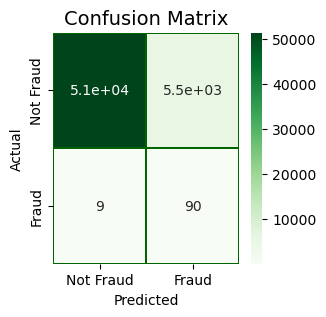

In [68]:
# Predictions

predictions = iso_clf.predict(test_df[predictors])

# Convert predictions +1 or -1 to the class of 0 or 1 respectively (Anomaly is -1)

y_pred = [1 if i == -1 else 0 for i in predictions]  # Convert -1 to 1 (Fraud) and 1 to 0 (Not Fraud)

# Confusion matrix

cm = pd.crosstab(test_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [69]:
# Classification Report

print(classification_report(test_df[target].values, y_pred, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with IsolationForestClassifier is {average_precision_score (test_df[target].values, y_pred):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      0.90      0.95     56863
       Fraud       0.02      0.91      0.03        99

    accuracy                           0.90     56962
   macro avg       0.51      0.91      0.49     56962
weighted avg       1.00      0.90      0.95     56962

Avg. Precision Score with IsolationForestClassifier is 0.0149


The recall score is over 90%, but the precision of 2% is will be a let down in real-life scenario

In [70]:
# iso_clf.feature_importances_

# have to implemeent the kernel SHAP as well as Tree SHAP for the Isolation Forests

### Local Outlier Factor

The LOF algorithm is an unsupervised outlier detection method which computes the local density deviation of a given data point with respect to its neighbors. It considers as outlier samples that have a substantially lower density than their neighbors.

The number of neighbors considered, (parameter n_neighbors) is typically chosen 1) greater than the minimum number of objects a cluster has to contain, so that other objects can be local outliers relative to this cluster, and 2) smaller than the maximum number of close by objects that can potentially be local outliers. In practice, such informations are generally not available, and taking n_neighbors=20 appears to work well in general.

##### c. With original outlier_fraction

In [71]:
# Outlier fraction

outlier_fraction = 0.0017304750013189597 # len(Fraud)/len(Not Fraud), retrived from the data_exploration.ipynb

# Classification model

lof_clf = LocalOutlierFactor(n_neighbors=20,
                            algorithm='auto',
                            leaf_size=30,
                            metric='minkowski',
                            p=2,
                            metric_params=None,
                            contamination=outlier_fraction,
                            novelty=True,
                            n_jobs=-1)  # Use -1 to utilize all available cores
# Fit the model

lof_clf.fit(train_without_validation_df[predictors])

LocalOutlierFactor(contamination=0.0017304750013189597, n_jobs=-1, novelty=True)

C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


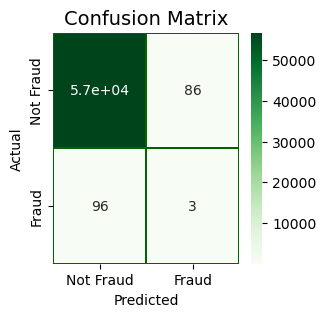

In [72]:
# Predictions

predictions = lof_clf.predict(test_df[predictors])

# Convert predictions +1 or -1 to the class of 0 or 1 respectively (Anomaly is -1)

y_pred = [1 if i == -1 else 0 for i in predictions]  # Convert -1 to 1 (Fraud) and 1 to 0 (Not Fraud)

# Confusion matrix

cm = pd.crosstab(test_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [73]:
# Classification Report

print(classification_report(test_df[target].values, y_pred, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with LocalOutlierFactorClassifier is {average_precision_score (test_df[target].values, y_pred):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      1.00      1.00     56863
       Fraud       0.03      0.03      0.03        99

    accuracy                           1.00     56962
   macro avg       0.52      0.51      0.52     56962
weighted avg       1.00      1.00      1.00     56962

Avg. Precision Score with LocalOutlierFactorClassifier is 0.0027


##### d. Without original outlier_fraction

C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  

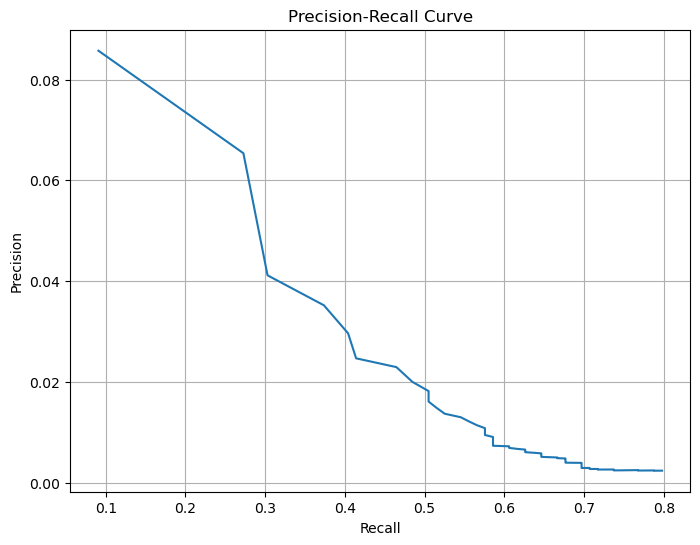

In [74]:
# Tuning the Local Outlier Factor model

rc = []
pc = []
i = outlier_fraction
while i <= 0.5:
    lof_clf = LocalOutlierFactor(n_neighbors=5,
                            algorithm='kd_tree', 
                            leaf_size=25,
                            metric='minkowski',
                            p=2,
                            metric_params=None,
                            contamination=i,
                            n_jobs=-1,
                            novelty=True)
    lof_clf.fit(train_without_validation_df[predictors])
    
    # Predictions
    y_pred = lof_clf.predict(test_df[predictors])
    
    # Convert -1 to 1 (outlier) and 1 to 0 (inlier)
    y_pred = [1 if i == -1 else 0 for i in y_pred]
    
    # Classification Report
    rc.append(recall_score(test_df[target].values, y_pred))
    pc.append(precision_score(test_df[target].values, y_pred))
    i += 0.005
    # if rc[-1] >= 0.95 or pc[-1] <= 0.001:
    #     break

plt.figure(figsize=(8, 6))
plt.plot(rc, pc)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid()
plt.show()

algorithm = 'ball_tree', 'kd_tree', 'brute'
- kd_tree is the fastest for this dataset
- then, ball_tree, and 
- brute takes the most time

n_neighbors = 30, 25, 20, 10, 5
- with 10 neighbors, contamination = outlier_fraction + 95*0.005
- with 20 neighbors, contamination = outlier_fraction + 99*0.005

leaf_size = 25, 30
- no effect on the performance, not going beyond 30 because of the following
    - Deeper tree, more nodes
    - Slower training, but potentially faster queries
    - More accurate local neighborhood structures

In [75]:
# Outlier fraction

outlier_fraction = 0.0017304750013189597 # len(Fraud)/len(Not Fraud), retrived from the data_exploration.ipynb

# Classification model

lof_clf = LocalOutlierFactor(n_neighbors=10, # Adjusted based on the tuning results
                            algorithm='kd_tree',
                            leaf_size=30,
                            metric='minkowski',
                            p=2,
                            metric_params=None,
                            contamination=outlier_fraction + 95*0.005,  # Adjusted contamination based on the tuning results
                            novelty=True,
                            n_jobs=-1)  # Use -1 to utilize all available cores
# Fit the model

lof_clf.fit(train_without_validation_df[predictors])

LocalOutlierFactor(algorithm='kd_tree', contamination=0.476730475001319,
                   n_jobs=-1, n_neighbors=10, novelty=True)

C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


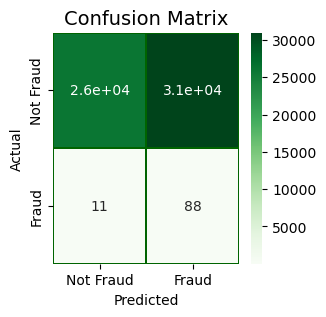

In [76]:
# Predictions

predictions = lof_clf.predict(test_df[predictors])

# Convert predictions +1 or -1 to the class of 0 or 1 respectively (Anomaly is -1)

y_pred = [1 if i == -1 else 0 for i in predictions]  # Convert -1 to 1 (Fraud) and 1 to 0 (Not Fraud)

# Confusion matrix

cm = pd.crosstab(test_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [77]:
# Classification Report

print(classification_report(test_df[target].values, y_pred, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with LocalOutlierFactorClassifier is {average_precision_score (test_df[target].values, y_pred):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      0.46      0.63     56863
       Fraud       0.00      0.89      0.01        99

    accuracy                           0.46     56962
   macro avg       0.50      0.67      0.32     56962
weighted avg       1.00      0.46      0.62     56962

Avg. Precision Score with LocalOutlierFactorClassifier is 0.0027


In [78]:
# Outlier fraction

outlier_fraction = 0.0017304750013189597 # len(Fraud)/len(Not Fraud), retrived from the data_exploration.ipynb

# Classification model

lof_clf = LocalOutlierFactor(n_neighbors=20, # Adjusted based on the tuning results
                            algorithm='kd_tree',
                            leaf_size=30,
                            metric='minkowski',
                            p=2,
                            metric_params=None,
                            contamination=outlier_fraction + 99*0.005,  # Adjusted contamination based on the tuning results
                            novelty=True,
                            n_jobs=-1)  # Use -1 to utilize all available cores
# Fit the model

lof_clf.fit(train_without_validation_df[predictors])

LocalOutlierFactor(algorithm='kd_tree', contamination=0.49673047500131895,
                   n_jobs=-1, novelty=True)

C:\Users\arkan\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


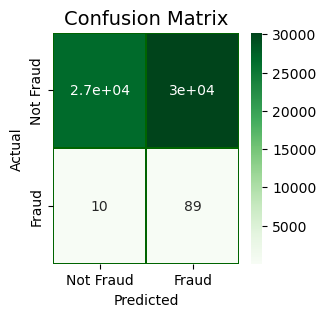

In [79]:
# Predictions

predictions = lof_clf.predict(test_df[predictors])

# Convert predictions +1 or -1 to the class of 0 or 1 respectively (Anomaly is -1)

y_pred = [1 if i == -1 else 0 for i in predictions]  # Convert -1 to 1 (Fraud) and 1 to 0 (Not Fraud)

# Confusion matrix

cm = pd.crosstab(test_df[target].values, y_pred, rownames=['Actual'], colnames=['Predicted'])
fig, (ax1) = plt.subplots(ncols=1, figsize=(3,3))
sns.heatmap(cm, 
            xticklabels=['Not Fraud', 'Fraud'],
            yticklabels=['Not Fraud', 'Fraud'],
            annot=True,ax=ax1,
            linewidths=.2,linecolor="Darkgreen", cmap="Greens")
plt.title('Confusion Matrix', fontsize=14)
plt.show()

In [80]:
# Classification Report

print(classification_report(test_df[target].values, y_pred, target_names=['Not Fraud', 'Fraud']))
print(f"Avg. Precision Score with LocalOutlierFactorClassifier is {average_precision_score (test_df[target].values, y_pred):.4f}")

              precision    recall  f1-score   support

   Not Fraud       1.00      0.47      0.64     56863
       Fraud       0.00      0.90      0.01        99

    accuracy                           0.47     56962
   macro avg       0.50      0.68      0.32     56962
weighted avg       1.00      0.47      0.64     56962

Avg. Precision Score with LocalOutlierFactorClassifier is 0.0028


Best recall is achieved at
- n_neighbors = 20
- algorithm = 'kd_tree'
- leaf_size = 30
- contamination ~ 0.5

But the precision has reduced to 0.002.

LOF may be not the best solution for this dataset

### Conclusion

In this experiment, multiple machine learning models—Random Forest, AdaBoost, XGBoost, Isolation Forest, and Local Outlier Factor—were evaluated for credit card fraud detection on an imbalanced dataset. Each model demonstrated unique strengths and limitations.

- Tree-based ensemble methods like Random Forest and XGBoost achieved high precision, making them effective at reducing false positives. However, their recall was limited without careful threshold tuning and class imbalance handling.

- AdaBoost performed comparably, offering a balance between bias and variance, but required tuning to match XGBoost’s performance.

- Isolation Forest was effective in detecting anomalies in an unsupervised manner, providing decent recall with faster training times.

- Local Outlier Factor, while sensitive to local data density, struggled with precision and computational efficiency, even after PCA and parameter optimization.

Overall, XGBoost with post-threshold tuning and class weight adjustment emerged as the most balanced model in terms of recall and precision, especially when aligned with business goals like minimizing false negatives while maintaining acceptable false positive rates. The experiment highlights the importance of model-specific tuning and threshold optimization in real-world fraud detection systems.